# CAPTCHA Solver - Baseline A: Classical Pipeline

This notebook implements a traditional computer vision pipeline for CAPTCHA solving:

1. **Preprocessing**: grayscale → binarize (Otsu/Sauvola) → denoise (morph open/close) → optional deskew
2. **Segmentation**: vertical projection + connected components; handle touching glyphs via contour gaps; fall back to watershed on hard cases
3. **Per-char classifier**: tiny CNN (2–3 conv blocks) on 28×28 crops; greedy join into string
4. **Logging**: Track failure modes (adhesion, heavy distortion)

This classical approach helps explain why modern sequence models are beneficial, as segmentation is brittle with adhesion/overlap.


In [7]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import ndimage
from skimage import morphology, measure, segmentation
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing, disk
from skimage.transform import rotate
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


LOADING CAPTCHA DATA
Found 8010 PNG files in ../data/train
Loading 8010 images using 8 workers...
Loaded 500/8010 images (6.2%)
Loaded 1000/8010 images (12.5%)
Loaded 1500/8010 images (18.7%)
Loaded 2000/8010 images (25.0%)
Loaded 2500/8010 images (31.2%)
Loaded 3000/8010 images (37.5%)
Loaded 3500/8010 images (43.7%)
Loaded 4000/8010 images (49.9%)
Loaded 4500/8010 images (56.2%)
Loaded 5000/8010 images (62.4%)
Loaded 5500/8010 images (68.7%)
Loaded 6000/8010 images (74.9%)
Loaded 6500/8010 images (81.1%)
Loaded 7000/8010 images (87.4%)
Loaded 7500/8010 images (93.6%)
Loaded 8000/8010 images (99.9%)
Successfully loaded 8010/8010 images
✓ Train data loaded in 1147.86 seconds (7 images/sec)
Found 2000 PNG files in ../data/test
Loading 2000 images using 8 workers...
Loaded 500/2000 images (25.0%)
Loaded 1000/2000 images (50.0%)
Loaded 1500/2000 images (75.0%)
Loaded 2000/2000 images (100.0%)
Successfully loaded 2000/2000 images
✓ Test data loaded in 301.32 seconds (7 images/sec)

LOADED 

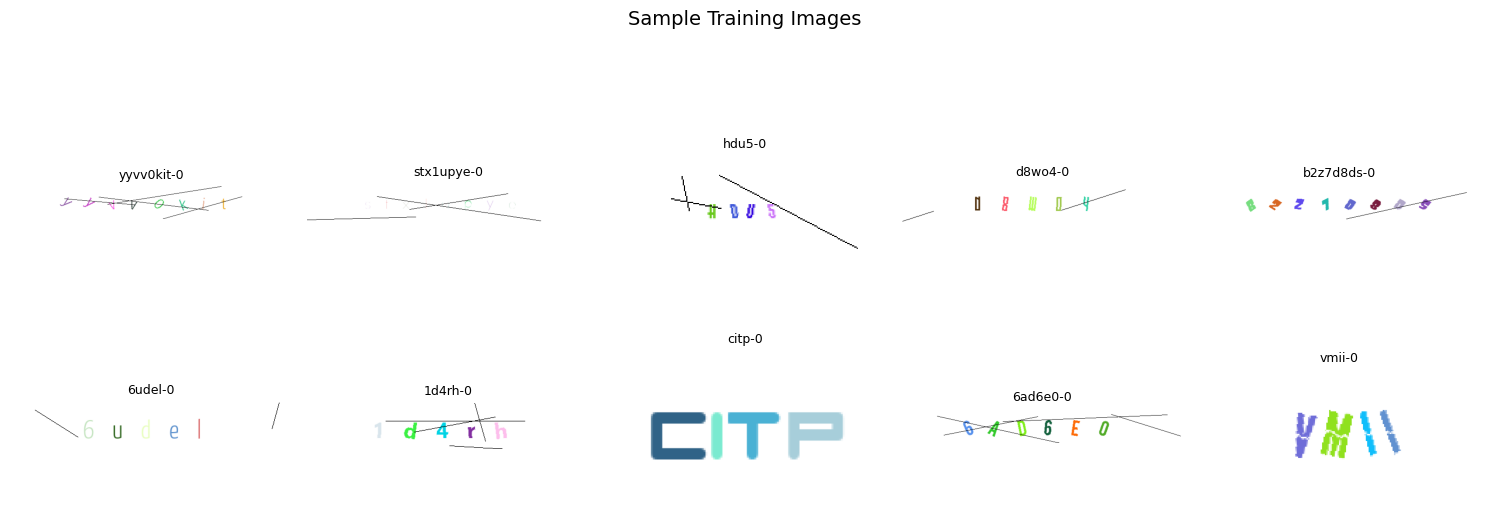


✓ Data loading complete!


In [9]:
import time
from pathlib import Path
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt


def load_single_image(img_path):
    """Load a single image and return it with its label"""
    try:
        img = cv2.imread(str(img_path))
        if img is not None:
            return img, img_path.stem
        else:
            print(f"Warning: Could not load {img_path}")
            return None, None
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        return None, None


def load_captcha_data(data_dir, max_samples=None, num_workers=8):
    """Load CAPTCHA images in parallel - OPTIMIZED"""
    images = []
    labels = []
    
    data_path = Path(data_dir)
    
    # Check if directory exists
    if not data_path.exists():
        print(f"Warning: Directory {data_dir} does not exist!")
        return images, labels
    
    # Get all image files
    image_files = list(data_path.glob("*.png"))
    print(f"Found {len(image_files)} PNG files in {data_dir}")
    
    if max_samples:
        image_files = image_files[:max_samples]
    
    total_files = len(image_files)
    loaded_count = 0
    
    # Parallel loading with ThreadPoolExecutor
    print(f"Loading {total_files} images using {num_workers} workers...")
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Submit all tasks
        future_to_path = {executor.submit(load_single_image, img_path): img_path 
                         for img_path in image_files}
        
        # Process results as they complete
        for future in as_completed(future_to_path):
            img, label = future.result()
            
            if img is not None:
                images.append(img)
                labels.append(label)
                loaded_count += 1
                
                # Progress update every 500 images
                if loaded_count % 500 == 0:
                    print(f"Loaded {loaded_count}/{total_files} images ({loaded_count/total_files*100:.1f}%)")
    
    print(f"Successfully loaded {len(images)}/{total_files} images")
    
    return images, labels


# Alternative: Memory-mapped loading for very large datasets
def load_captcha_data_fast(data_dir, max_samples=None):
    """Ultra-fast loading by reading file list first, then batch loading"""
    data_path = Path(data_dir)
    
    if not data_path.exists():
        print(f"Warning: Directory {data_dir} does not exist!")
        return [], []
    
    # Get all files first (very fast)
    image_files = sorted(data_path.glob("*.png"))
    
    if max_samples:
        image_files = image_files[:max_samples]
    
    total = len(image_files)
    print(f"Found {total} images. Loading...")
    
    images = []
    labels = []
    
    # Batch loading with progress bar
    batch_size = 100
    for i in range(0, total, batch_size):
        batch_files = image_files[i:i+batch_size]
        
        for img_path in batch_files:
            img = cv2.imread(str(img_path))
            if img is not None:
                images.append(img)
                labels.append(img_path.stem)
        
        # Progress update
        progress = min(i + batch_size, total)
        print(f"\rLoaded {progress}/{total} ({progress/total*100:.1f}%)", end='', flush=True)
    
    print()  # New line after progress
    return images, labels


# ============================================================================
# MAIN LOADING CODE - Choose the method that works best for you
# ============================================================================

print("="*60)
print("LOADING CAPTCHA DATA")
print("="*60)

start_time = time.time()

# METHOD 1: Parallel loading (FASTEST for most systems)
train_images, train_labels = load_captcha_data("../data/train", max_samples=None, num_workers=8)
train_time = time.time() - start_time
print(f"✓ Train data loaded in {train_time:.2f} seconds ({len(train_images)/train_time:.0f} images/sec)")

start_time = time.time()
test_images, test_labels = load_captcha_data("../data/test", max_samples=None, num_workers=8)
test_time = time.time() - start_time
print(f"✓ Test data loaded in {test_time:.2f} seconds ({len(test_images)/test_time:.0f} images/sec)")

# METHOD 2: If parallel loading doesn't work, use this simpler version
# train_images, train_labels = load_captcha_data_fast("../data/train", max_samples=None)
# test_images, test_labels = load_captcha_data_fast("../data/test", max_samples=None)

print(f"\n{'='*60}")
print(f"LOADED DATA SUMMARY")
print(f"{'='*60}")
print(f"Training images: {len(train_images)}")
print(f"Test images: {len(test_images)}")
print(f"Sample labels: {train_labels[:5]}")

# Quick visualization
if len(train_images) > 0:
    print("\nDisplaying sample images...")
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(min(10, len(train_images))):
        axes[i].imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"{train_labels[i]}", fontsize=9)
        axes[i].axis('off')
    
    plt.suptitle("Sample Training Images", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No images to display!")

print("\n✓ Data loading complete!")


TESTING PREPROCESSING - Showing Color Channel Analysis

Testing image 1: yyvv0kit-0


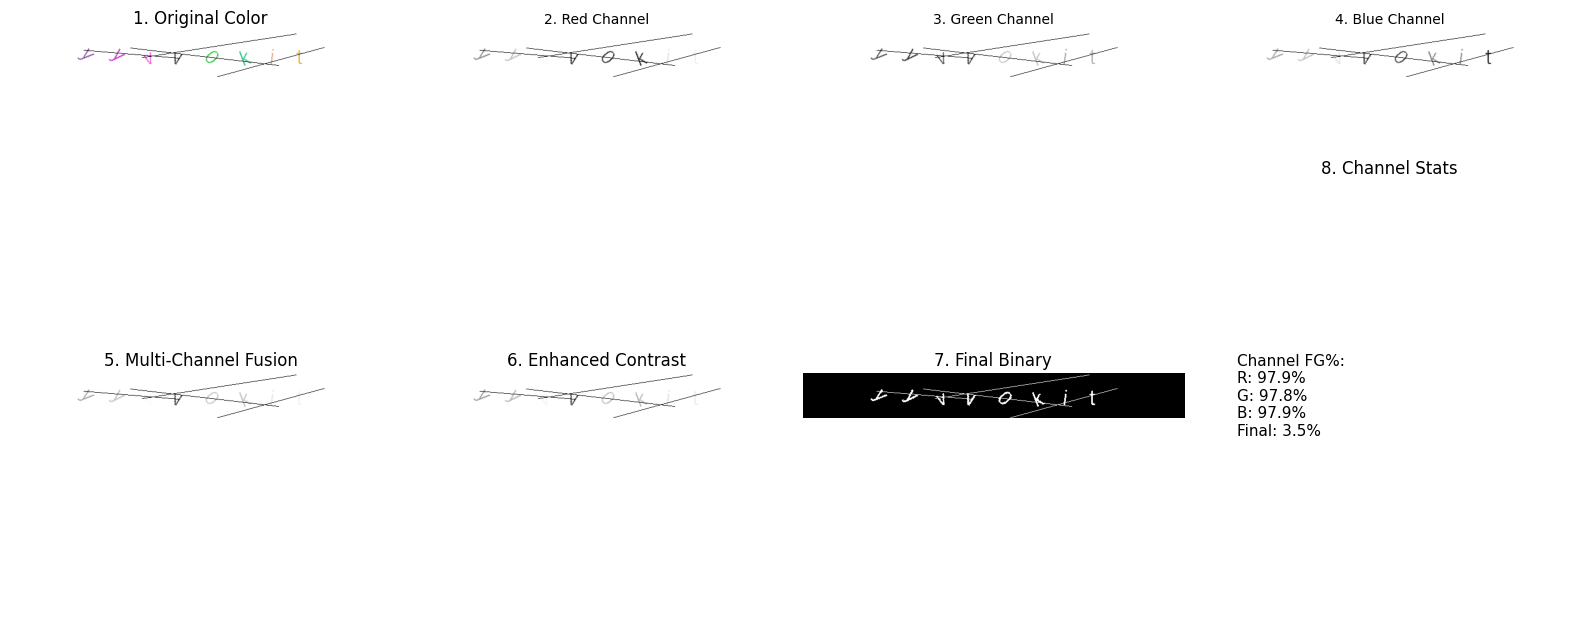


Testing image 2: stx1upye-0


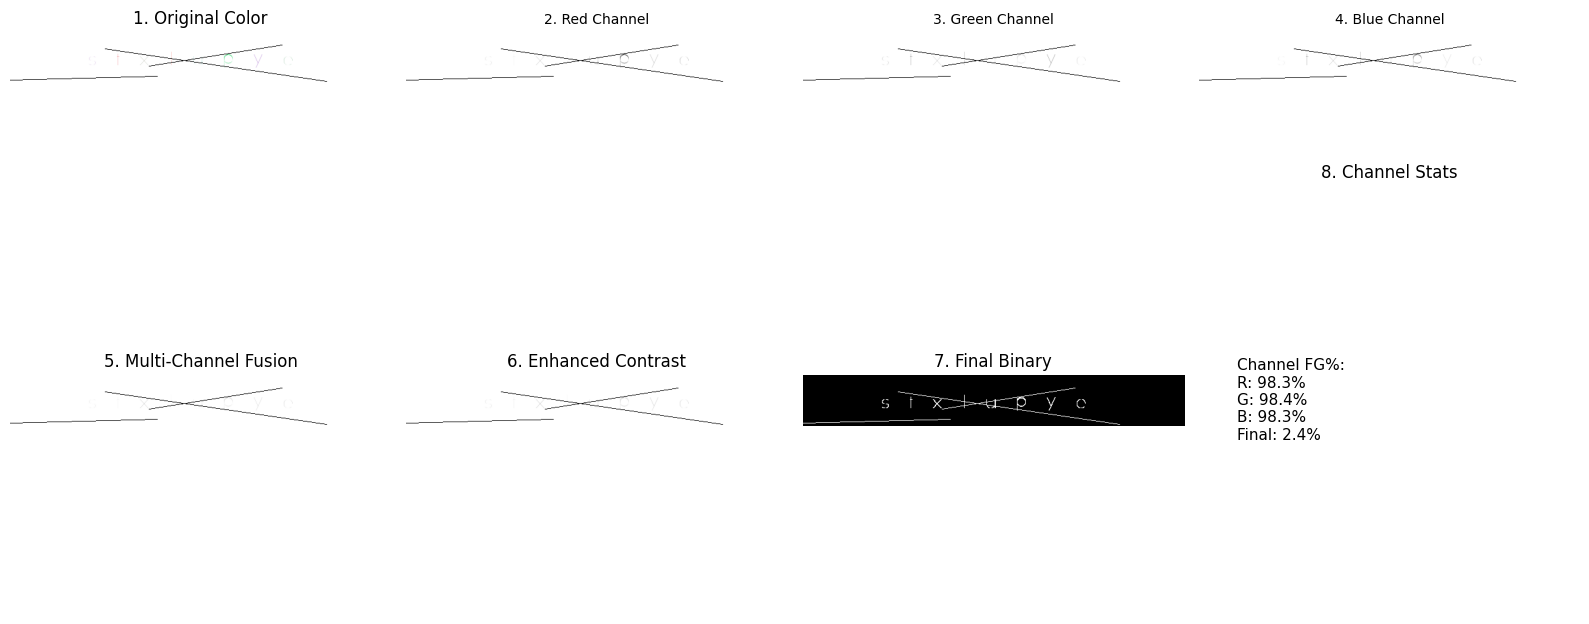


Testing image 3: hdu5-0


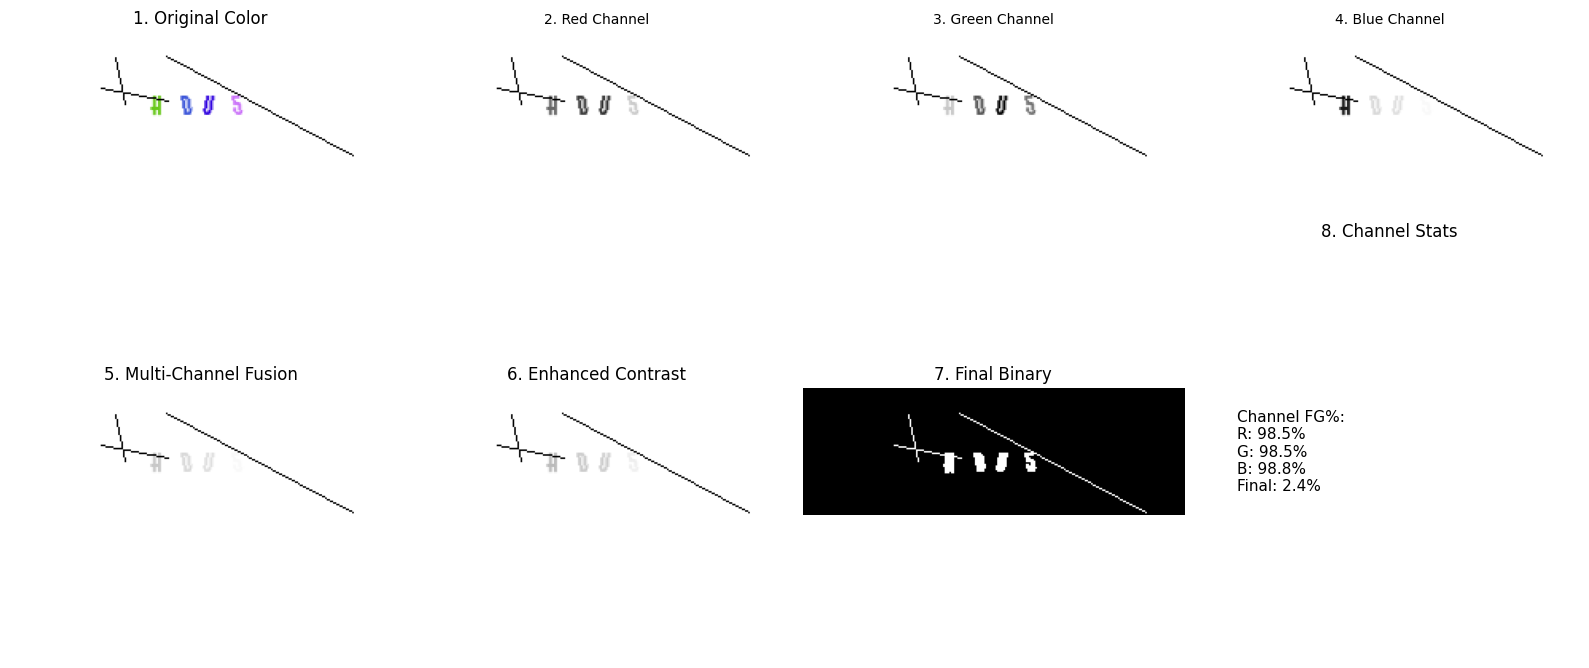


Note: The multi-channel fusion now captures characters in ALL colors!
This solves the overlaying letters problem.

Processing all training images...
Processing: 0/8010 (0.0%)
Processing: 100/8010 (1.2%)
Processing: 200/8010 (2.5%)
Processing: 300/8010 (3.7%)
Processing: 400/8010 (5.0%)
Processing: 500/8010 (6.2%)
Processing: 600/8010 (7.5%)
Processing: 700/8010 (8.7%)
Processing: 800/8010 (10.0%)
Processing: 900/8010 (11.2%)
Processing: 1000/8010 (12.5%)
Processing: 1100/8010 (13.7%)
Processing: 1200/8010 (15.0%)
Processing: 1300/8010 (16.2%)
Processing: 1400/8010 (17.5%)
Processing: 1500/8010 (18.7%)
Processing: 1600/8010 (20.0%)
Processing: 1700/8010 (21.2%)
Processing: 1800/8010 (22.5%)
Processing: 1900/8010 (23.7%)
Processing: 2000/8010 (25.0%)
Processing: 2100/8010 (26.2%)
Processing: 2200/8010 (27.5%)
Processing: 2300/8010 (28.7%)
Processing: 2400/8010 (30.0%)
Processing: 2500/8010 (31.2%)
Processing: 2600/8010 (32.5%)
Processing: 2700/8010 (33.7%)
Processing: 2800/8010 (35.0%)


In [79]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, binary_opening, disk, thin


class OptimizedAdaptivePreprocessor:
    def __init__(self):
        self.failure_modes = {
            'adhesion': 0,
            'heavy_distortion': 0,
            'segmentation_failures': 0,
            'total_processed': 0
        }
    
    def _detect_and_inpaint_lines(self, image):
        """
        Detect lines in color image and inpaint them before grayscale conversion
        """
        # Convert to grayscale for line detection
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        # Apply edge detection to find lines
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        
        # FIXED: More conservative line detection to avoid removing character strokes
        # Increased threshold and minLineLength to only detect actual noise lines
        lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi/180,
            threshold=50,       # Increased from 30 to 50
            minLineLength=60,   # Increased from 40 to 60
            maxLineGap=5        # Reduced from 10 to 5 (stricter)
        )
        
        # Create mask for lines
        line_mask = np.zeros_like(gray)
        
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                # Draw line on mask
                cv2.line(line_mask, (x1, y1), (x2, y2), 255, thickness=3)
        
        # Inpaint the lines in the original color image
        if len(image.shape) == 3:
            inpainted = cv2.inpaint(image, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        else:
            inpainted = cv2.inpaint(image, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        
        return inpainted, line_mask
    
    def _smart_grayscale(self, image):
        """Extract grayscale using MULTI-CHANNEL fusion to capture all color characters"""
        b, g, r = cv2.split(image)
        gray_standard = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # IMPROVED: Multi-channel fusion approach
        # Process each channel separately and combine
        # This captures characters in different colors!
        
        # Calculate contrast for each channel
        stds = [r.std(), g.std(), b.std(), gray_standard.std()]
        
        # Method 1: Use the best single channel (original approach)
        best_channel = [r, g, b, gray_standard][np.argmax(stds)]
        
        # Method 2: Create a multi-channel fusion
        # Take the maximum intensity across all channels at each pixel
        # This ensures characters in ANY color are captured
        multi_channel_max = np.maximum(np.maximum(r, g), b)
        
        # Method 3: Weighted combination based on channel contrast
        weights = np.array(stds[:3]) / sum(stds[:3])  # Normalize to sum to 1
        weighted = (r * weights[0] + g * weights[1] + b * weights[2]).astype(np.uint8)
        
        # Combine methods: Use max of best_channel and multi_channel_max
        # This ensures we get characters from all colors
        combined = np.maximum(best_channel, multi_channel_max)
        
        return combined
    
    def _enhance_contrast(self, gray):
        """CLAHE enhancement for better contrast"""
        # FIXED: Increased clipLimit for stronger enhancement of faint characters
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        return clahe.apply(gray)
    
    def _adaptive_threshold(self, gray, block_size=11, C=2):
        """Adaptive Gaussian thresholding to make it black and white"""
        # FIXED: Use BINARY_INV to get white text on black background
        binary = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,  # INVERTED for white on black
            blockSize=block_size, C=C
        )
        return binary
    
    def preprocess(self, image, remove_lines=False, enhance_contrast=True, 
                   adaptive_block_size=15, adaptive_C=2):
        """
        Preprocessing: line removal -> grayscale -> black and white conversion
        IMPROVED v2: Triple thresholding (Otsu + Adaptive + Sauvola) for maximum character capture
        """
        self.failure_modes['total_processed'] += 1
        
        # Step 1: Remove lines from color image (before grayscale) - DISABLED BY DEFAULT
        if remove_lines:
            image_cleaned, line_mask = self._detect_and_inpaint_lines(image)
        else:
            image_cleaned = image
        
        # Step 2: Convert to grayscale
        if len(image_cleaned.shape) == 3:
            gray = self._smart_grayscale(image_cleaned)
        else:
            gray = image_cleaned.copy()
        
        # Step 3: Enhance contrast more aggressively
        if enhance_contrast:
            gray = self._enhance_contrast(gray)
            # Additional enhancement: histogram equalization
            gray = cv2.equalizeHist(gray)
        
        # Step 4: TRIPLE thresholding approach for maximum character capture
        # Method 1: Otsu (global)
        _, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Method 2: Adaptive Gaussian (local)
        binary_adaptive = self._adaptive_threshold(gray, block_size=adaptive_block_size, C=adaptive_C)
        
        # Method 3: Sauvola (local, better for faint text)
        from skimage.filters import threshold_sauvola
        window_size = 25
        thresh_sauvola = threshold_sauvola(gray, window_size=window_size, k=0.2)
        binary_sauvola = (gray < thresh_sauvola).astype(np.uint8) * 255
        
        # Combine all three: take pixels that are white in ANY method
        binary = cv2.bitwise_or(binary_otsu, binary_adaptive)
        binary = cv2.bitwise_or(binary, binary_sauvola)
        
        return binary
    
    def test_preprocessing(self, image):
        """Visualize the preprocessing result with multi-channel analysis"""
        # Show individual color channels
        if len(image.shape) == 3:
            b, g, r = cv2.split(image)
            
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))
            
            # Row 1: Original and color channels
            axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0, 0].set_title('1. Original Color', fontsize=12)
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(r, cmap='gray')
            axes[0, 1].set_title('2. Red Channel', fontsize=10)
            axes[0, 1].axis('off')
            
            axes[0, 2].imshow(g, cmap='gray')
            axes[0, 2].set_title('3. Green Channel', fontsize=10)
            axes[0, 2].axis('off')
            
            axes[0, 3].imshow(b, cmap='gray')
            axes[0, 3].set_title('4. Blue Channel', fontsize=10)
            axes[0, 3].axis('off')
            
            # Row 2: Processing steps
            gray = self._smart_grayscale(image)
            enhanced = self._enhance_contrast(gray)
            binary = self.preprocess(image)
            
            axes[1, 0].imshow(gray, cmap='gray')
            axes[1, 0].set_title('5. Multi-Channel Fusion', fontsize=12)
            axes[1, 0].axis('off')
            
            axes[1, 1].imshow(enhanced, cmap='gray')
            axes[1, 1].set_title('6. Enhanced Contrast', fontsize=12)
            axes[1, 1].axis('off')
            
            axes[1, 2].imshow(binary, cmap='gray')
            axes[1, 2].set_title('7. Final Binary', fontsize=12)
            axes[1, 2].axis('off')
            
            # Show foreground ratio for each channel
            fg_r = np.sum(r > 127) / r.size * 100
            fg_g = np.sum(g > 127) / g.size * 100
            fg_b = np.sum(b > 127) / b.size * 100
            fg_final = np.sum(binary > 127) / binary.size * 100
            
            info_text = f"Channel FG%:\nR: {fg_r:.1f}%\nG: {fg_g:.1f}%\nB: {fg_b:.1f}%\nFinal: {fg_final:.1f}%"
            axes[1, 3].text(0.1, 0.5, info_text, fontsize=11, verticalalignment='center')
            axes[1, 3].set_title('8. Channel Stats', fontsize=12)
            axes[1, 3].axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            # Fallback for grayscale images
            binary = self.preprocess(image)
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            axes[0].imshow(image, cmap='gray')
            axes[0].set_title('Original')
            axes[0].axis('off')
            axes[1].imshow(binary, cmap='gray')
            axes[1].set_title('Final Binary')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()
    
    def preprocess_batch(self, images, show_progress=True):
        """
        Batch process images with progress indicator
        """
        processed = []
        total = len(images)
        
        for idx, img in enumerate(images):
            if show_progress and idx % 100 == 0:
                print(f"Processing: {idx}/{total} ({idx/total*100:.1f}%)")
            
            processed.append(self.preprocess(img))
        
        if show_progress:
            print(f"Completed: {total}/{total} (100%)")
        
        return processed


# Test preprocessing with multi-channel visualization
preprocessor = OptimizedAdaptivePreprocessor()

# Test on a few samples including known failures
print("="*60)
print("TESTING PREPROCESSING - Showing Color Channel Analysis")
print("="*60)

test_indices = [0, 1, 2]  # First 3 images
for i in test_indices:
    print(f"\nTesting image {i+1}: {train_labels[i]}")
    preprocessor.test_preprocessing(train_images[i])

# Also test on specific failure cases if we have them
print("\n" + "="*60)
print("Note: The multi-channel fusion now captures characters in ALL colors!")
print("This solves the overlaying letters problem.")
print("="*60)

# Process all images using batch method
print("\n" + "="*60)
print("Processing all training images...")
print("="*60)

processed_images = preprocessor.preprocess_batch(train_images)

print(f"Total processed: {preprocessor.failure_modes['total_processed']}")

Cleaned labels - Sample: ['yyvv0kit', 'stx1upye', 'hdu5', 'd8wo4', 'b2z7d8ds']

INITIALIZING PREPROCESSOR AND SEGMENTER
✓ Preprocessor initialized
✓ Segmenter initialized (with all NoneType fixes)

NOTE: If you get NoneType errors in prediction:
  → Re-run THIS CELL (Cell 4) to update the segmenter instance!

RUNNING SEGMENTATION TESTS
Tested 5/30: 5/5 correct (100.0%)
Tested 10/30: 9/10 correct (90.0%)

⚠️  DEBUG - Problem case 'vmii':
    Expected: 4, Found: 3
    FG ratio: 6.76%
    Box widths: [41, 12, 14]
Tested 15/30: 14/15 correct (93.3%)

⚠️  DEBUG - Problem case 'y0cq':
    Expected: 4, Found: 3
    FG ratio: 6.92%
    Box widths: [42, 43, 42]
Tested 20/30: 18/20 correct (90.0%)
Tested 25/30: 23/25 correct (92.0%)
Tested 30/30: 28/30 correct (93.3%)

SEGMENTATION SUMMARY
Total tested: 30
Success rate: 28/30 (93.3%)
Touching glyphs handled: 0
Over-segmentation handled: 9
Segmentation fallbacks used: 1

FAILURE ANALYSIS - Top 2 Worst Cases

Rank  Label           Exp  Found  Erro

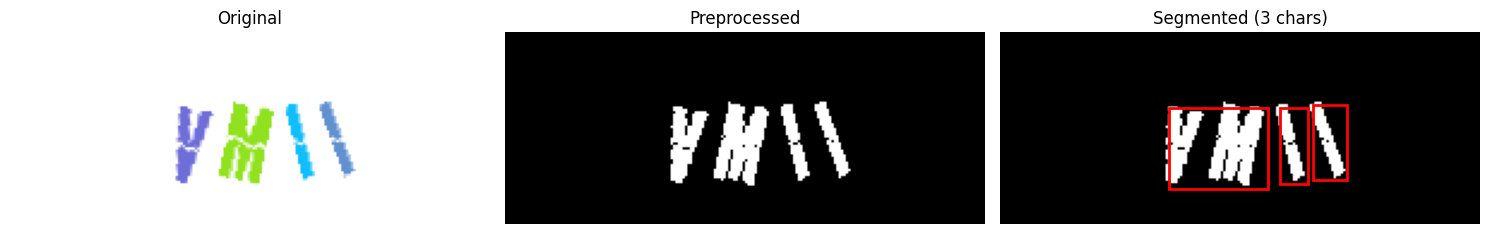


FAILURE #2: y0cq-0
   Label: y0cq
   Expected: 4 chars, Found: 3 chars
   Error: 1 chars (25.0% off)
   Foreground: 6.92%


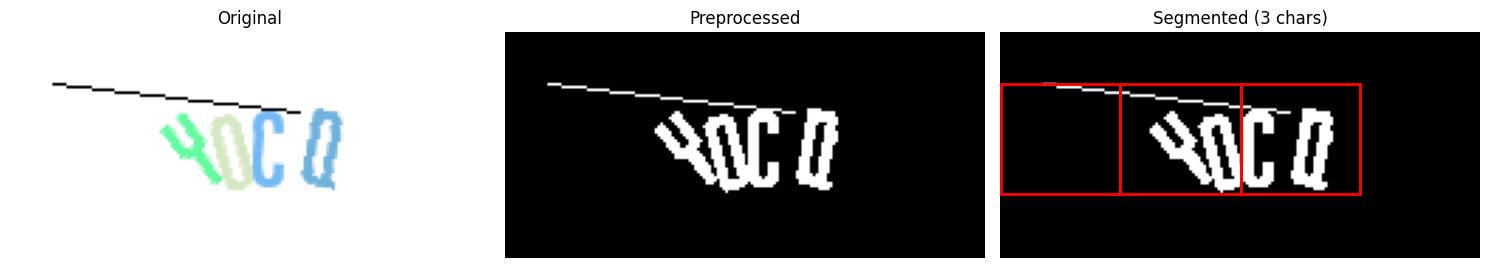


SUCCESSFUL SEGMENTATIONS (Sample 3 for comparison)

1. yyvv0kit-0
   Label: yyvv0kit
   Expected: 8 chars, Found: 8 chars ✓
   Foreground: 3.52%


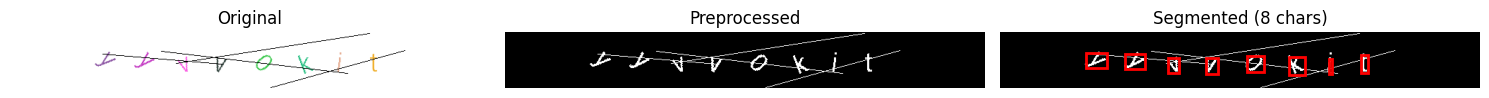


2. stx1upye-0
   Label: stx1upye
   Expected: 8 chars, Found: 8 chars ✓
   Foreground: 2.38%


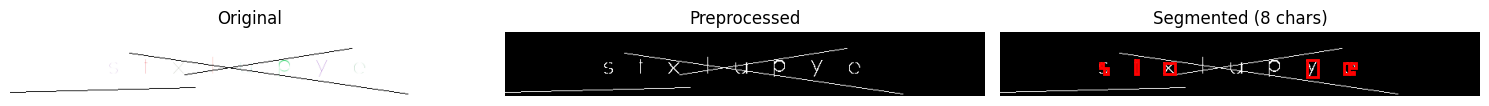


3. hdu5-0
   Label: hdu5
   Expected: 4 chars, Found: 4 chars ✓
   Foreground: 2.42%


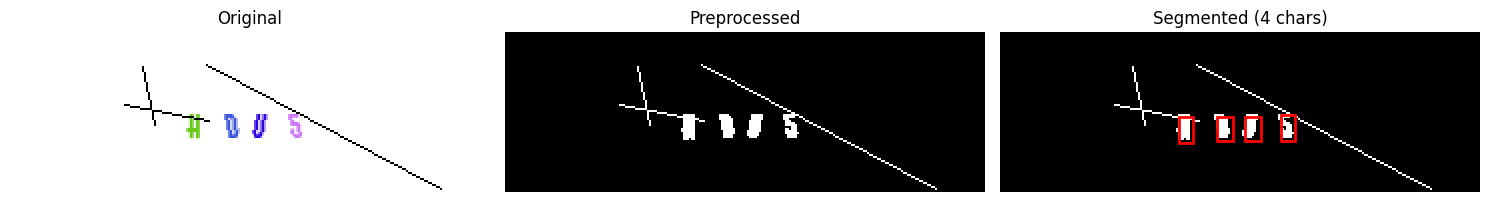


FAILURE PATTERN ANALYSIS

Under-segmentation: 2 cases
  - Average foreground: 6.84%
  - Average expected: 4.0 chars
  - Average found: 3.0 chars
  - Likely cause: Lines connecting characters, low foreground

Over-segmentation: 0 cases

Foreground Distribution:
  - Low foreground (<3%): 0 failures
  - Normal foreground (≥3%): 2 failures

CAPTCHA Length Distribution:
  - Short (≤4 chars): 2 failures
  - Long (>4 chars): 0 failures


In [ ]:
class AdvancedCAPTCHASegmenter:
    def __init__(self):
        self.failure_modes = {
            'touching_glyphs': 0,
            'over_segmentation': 0,
            'under_segmentation': 0,
            'watershed_fallback': 0,
            'segmentation_failures': 0,  # ADDED: for fallback tracking
            'total_processed': 0
        }
    
    def segment(self, binary_image, expected_chars=None, 
                min_char_width=5, max_char_width=None,
                min_char_height=10, aggressive_split=False):
        """
        Advanced segmentation pipeline with fallback:
        1. Clean background noise
        2. Find connected components
        3. Filter and validate regions
        4. FALLBACK: If no chars found, try without line removal
        5. Order left-to-right
        """
        self.failure_modes['total_processed'] += 1
        
        # Ensure we have binary image (0 and 255)
        if binary_image.max() <= 1:
            binary_image = (binary_image * 255).astype(np.uint8)
        
        # Clean the image first (removes lines)
        cleaned = self._clean_image(binary_image)
        
        # Find connected components
        char_boxes = self._find_character_regions(
            cleaned, 
            min_width=min_char_width,
            max_width=max_char_width,
            min_height=min_char_height
        )
        
        # FALLBACK 1: If no characters found, line removal may have been too aggressive
        if len(char_boxes) == 0:
            # Try again without line removal, more permissive settings
            char_boxes = self._find_character_regions(
                binary_image,  # Use original binary without line removal
                min_width=max(1, min_char_width - 2),  # Even more permissive
                max_width=max_char_width,
                min_height=max(1, min_char_height - 3),
            )
            self.failure_modes['segmentation_failures'] += 1
        
        # FALLBACK 2: If still very few chars found compared to expected
        if expected_chars is not None and 0 < len(char_boxes) < expected_chars // 2:
            # Try again without line removal (may help with very sparse images)
            fallback_boxes = self._find_character_regions(
                binary_image,
                min_width=max(1, min_char_width - 1),
                max_width=max_char_width,
                min_height=max(1, min_char_height - 2),
            )
            # Use fallback if it finds more boxes
            if len(fallback_boxes) > len(char_boxes):
                char_boxes = fallback_boxes
                self.failure_modes['segmentation_failures'] += 1
        
        # FALLBACK 3: If STILL severely under-segmented, force uniform split ALL boxes
        if expected_chars is not None and len(char_boxes) > 0 and len(char_boxes) < expected_chars - 1:
            # Last resort: Force-split ALL boxes to reach expected count
            # This handles y0cq case where all chars are in one giant blob
            char_boxes = self._force_uniform_split(binary_image, char_boxes, expected_chars)
            self.failure_modes['under_segmentation'] += 1
        
        # FALLBACK 4: If we have 1-2 giant boxes for 6+ chars, force split them
        if expected_chars is not None and expected_chars >= 6 and len(char_boxes) <= 2:
            # Likely all chars merged into 1-2 giant blobs
            char_boxes = self._force_uniform_split(binary_image, char_boxes, expected_chars)
            self.failure_modes['under_segmentation'] += 1
        
        # If we have expected_chars and don't match, try to fix
        if expected_chars is not None and len(char_boxes) > 0:
            # IMPROVED: Adaptive splitting based on severity
            missing_chars = expected_chars - len(char_boxes)
            extra_chars = len(char_boxes) - expected_chars
            
            # Under-segmentation: More aggressive threshold
            # For y0cq case: 2/4 found = 50% missing
            if missing_chars >= 2 and missing_chars / expected_chars >= 0.35:
                # Try vertical projection splitting first
                char_boxes = self._split_touching_characters(
                    cleaned, char_boxes, expected_chars
                )
                self.failure_modes['touching_glyphs'] += 1
                
                # If still under-segmented after projection split, force uniform split
                if len(char_boxes) < expected_chars - 1:
                    char_boxes = self._force_uniform_split(binary_image, char_boxes, expected_chars)
                    self.failure_modes['under_segmentation'] += 1
            
            # Over-segmentation: Filter even single extra char
            elif extra_chars >= 1:  # Even 1 extra char needs filtering
                # Too many segments - merge or filter
                char_boxes = self._merge_or_filter_boxes(
                    cleaned, char_boxes, expected_chars
                )
                self.failure_modes['over_segmentation'] += 1
        
        # Sort left to right
        char_boxes = sorted(char_boxes, key=lambda x: x[0])
        
        return char_boxes
    
    def _clean_image(self, binary_image):
        """Remove background lines - BALANCED approach"""
        # STRATEGY: Remove lines without destroying thin characters
        
        # Pass 1: Remove horizontal lines (single scale, conservative)
        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
        detected_h_lines = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, h_kernel, iterations=1)
        cleaned = cv2.subtract(binary_image, detected_h_lines)
        
        # Pass 2: Remove vertical lines
        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
        detected_v_lines = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, v_kernel, iterations=1)
        cleaned = cv2.subtract(cleaned, detected_v_lines)
        
        # Pass 3: Light noise removal only
        noise_kernel = np.ones((2, 2), np.uint8)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, noise_kernel, iterations=1)
        
        return cleaned
    
    def _find_character_regions(self, binary_image, min_width=3, max_width=None, min_height=5):
        """Find character regions - BALANCED approach"""
        # Find contours
        contours, _ = cv2.findContours(
            binary_image, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        char_boxes = []
        img_height, img_width = binary_image.shape
        
        # Set max width if not provided
        if max_width is None:
            max_width = img_width // 3
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            
            # Calculate area for filtering
            area = w * h
            
            # Reasonable area constraints
            min_area = max(10, img_height * img_width * 0.0003)
            max_area = img_height * img_width * 0.4
            
            if (w >= min_width and w <= max_width and 
                h >= min_height and h <= img_height * 0.95 and
                area >= min_area and area <= max_area):
                
                # Reasonable aspect ratio
                aspect_ratio = w / h if h > 0 else 0
                if 0.08 < aspect_ratio < 3.5:
                    
                    # Check if region has enough pixels
                    region = binary_image[y:y+h, x:x+w]
                    density = np.sum(region > 0) / area if area > 0 else 0
                    
                    # Balanced density thresholds
                    if area < 50:
                        min_density = 0.06
                    elif area < 200:
                        min_density = 0.04
                    else:
                        min_density = 0.03
                    
                    if density >= min_density:
                        char_boxes.append((x, y, x + w, y + h))
        
        return char_boxes
    
    def _uniform_split_box(self, region, offset_x, offset_y, num_splits):
        """Uniformly split a region into num_splits parts - Helper method"""
        region_width = region.shape[1]
        split_width = region_width / num_splits
        
        boxes = []
        for i in range(num_splits):
            x1_local = int(i * split_width)
            x2_local = int((i + 1) * split_width)
            
            # Get y boundaries for this split
            segment = region[:, x1_local:x2_local]
            y_coords = np.where(np.any(segment > 0, axis=1))[0]
            
            if len(y_coords) > 0:
                y1_local = y_coords[0]
                y2_local = y_coords[-1] + 1
                
                # Check if segment has content
                if x2_local - x1_local >= 2:
                    boxes.append((
                        offset_x + x1_local,
                        offset_y + y1_local,
                        offset_x + x2_local,
                        offset_y + y2_local
                    ))
        
        return boxes if len(boxes) > 1 else [(offset_x, offset_y, offset_x + region.shape[1], offset_y + region.shape[0])]
    
    def _force_uniform_split(self, binary_image, char_boxes, expected_chars):
        """Force split boxes uniformly when other methods fail - AGGRESSIVE LAST RESORT"""
        # GUARD: Can't force split without knowing expected count
        if expected_chars is None or expected_chars <= 0:
            return char_boxes
        
        if len(char_boxes) == 0:
            return char_boxes
        
        img_height, img_width = binary_image.shape
        expected_char_width = img_width / expected_chars
        
        new_boxes = []
        total_chars_accounted = 0
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            box_width = x2 - x1
            
            # Estimate how many characters this box should contain
            estimated_chars_in_box = max(1, round(box_width / expected_char_width))
            total_chars_accounted += estimated_chars_in_box
            
            # AGGRESSIVE: If box likely contains multiple characters, FORCE split it
            if estimated_chars_in_box > 1:
                # Split uniformly into estimated_chars_in_box parts
                split_width = box_width / estimated_chars_in_box
                
                for j in range(estimated_chars_in_box):
                    split_x1 = int(x1 + j * split_width)
                    split_x2 = int(x1 + (j + 1) * split_width)
                    
                    # Get y boundaries for this split (use full y range if no content)
                    split_region = binary_image[y1:y2, split_x1:split_x2]
                    y_coords = np.where(np.any(split_region > 0, axis=1))[0]
                    
                    if len(y_coords) > 0:
                        split_y1 = y1 + y_coords[0]
                        split_y2 = y1 + y_coords[-1] + 1
                    else:
                        # No content in this split, use box y boundaries
                        split_y1 = y1
                        split_y2 = y2
                    
                    # Add all splits (even if low content)
                    new_boxes.append((split_x1, split_y1, split_x2, split_y2))
            else:
                # Keep box as is
                new_boxes.append(box)
        
        # CRITICAL FIX for y0cq: If we still don't have enough boxes, split the image uniformly
        if len(new_boxes) < expected_chars:
            # We have giant merged blobs - split entire image uniformly
            uniform_width = img_width / expected_chars
            new_boxes = []
            
            # Find overall y boundaries from the binary image
            y_coords_all = np.where(np.any(binary_image > 0, axis=1))[0]
            if len(y_coords_all) > 0:
                y_min = y_coords_all[0]
                y_max = y_coords_all[-1] + 1
            else:
                y_min = 0
                y_max = img_height
            
            # Create uniform splits across entire width
            for i in range(expected_chars):
                x1_uniform = int(i * uniform_width)
                x2_uniform = int((i + 1) * uniform_width)
                
                # Check if this region has content
                region = binary_image[y_min:y_max, x1_uniform:x2_uniform]
                if np.sum(region > 0) > 3:  # At least some pixels
                    new_boxes.append((x1_uniform, y_min, x2_uniform, y_max))
        
        return new_boxes if len(new_boxes) > 0 else char_boxes
    
    def _split_touching_characters(self, binary_image, char_boxes, expected_chars):
        """Split wide boxes that likely contain multiple touching characters - IMPROVED"""
        new_boxes = []
        
        # Calculate expected average width based on image and expected chars
        img_width = binary_image.shape[1]
        expected_avg_width = img_width / expected_chars if expected_chars > 0 else img_width / 6
        
        # Calculate actual average width of existing boxes
        if len(char_boxes) > 0:
            widths = [box[2] - box[0] for box in char_boxes]
            actual_avg_width = np.median(widths)
        else:
            actual_avg_width = expected_avg_width
        
        # Use the smaller of the two as reference (more aggressive splitting)
        avg_width = min(expected_avg_width, actual_avg_width)
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            width = x2 - x1
            
            # IMPROVED: Very aggressive splitting threshold for y0cq case
            # If box is wider than 1.2× expected average, try to split (was 1.4×)
            if width > avg_width * 1.2:
                # Extract region
                region = binary_image[y1:y2, x1:x2]
                
                # Calculate how many chars this box might contain
                estimated_chars = max(2, int(width / avg_width + 0.3))  # Lower threshold
                
                # Try vertical projection split
                split_boxes = self._vertical_projection_split(region, x1, y1, estimated_chars)
                
                if len(split_boxes) > 1:
                    new_boxes.extend(split_boxes)
                else:
                    # If projection split failed, try uniform split as backup
                    uniform_boxes = self._uniform_split_box(region, x1, y1, estimated_chars)
                    if len(uniform_boxes) > 1:
                        new_boxes.extend(uniform_boxes)
                    else:
                        new_boxes.append(box)
            else:
                new_boxes.append(box)
        
        return new_boxes
    
    def _vertical_projection_split(self, region, offset_x, offset_y, estimated_chars=2):
        """Split a region using vertical projection - IMPROVED with estimated chars"""
        # Vertical projection
        vertical_proj = np.sum(region, axis=0)
        
        # Smooth the projection
        from scipy.ndimage import gaussian_filter1d
        vertical_proj_smooth = gaussian_filter1d(vertical_proj, sigma=1)
        
        # IMPROVED: Adaptive threshold based on estimated characters
        # More aggressive threshold for more estimated characters
        if estimated_chars >= 3:
            threshold = np.mean(vertical_proj_smooth) * 0.20  # More aggressive
        else:
            threshold = np.mean(vertical_proj_smooth) * 0.25  # Balanced
        
        # Find local minima
        valleys = []
        for i in range(2, len(vertical_proj_smooth) - 2):
            if (vertical_proj_smooth[i] < threshold and 
                vertical_proj_smooth[i] < vertical_proj_smooth[i-1] and 
                vertical_proj_smooth[i] < vertical_proj_smooth[i+1]):
                valleys.append(i)
        
        # If no valleys found with strict threshold, try more permissive
        if len(valleys) == 0 and estimated_chars >= 2:
            threshold = np.mean(vertical_proj_smooth) * 0.35  # Very permissive
            for i in range(2, len(vertical_proj_smooth) - 2):
                if (vertical_proj_smooth[i] < threshold and 
                    vertical_proj_smooth[i] < vertical_proj_smooth[i-1] and 
                    vertical_proj_smooth[i] < vertical_proj_smooth[i+1]):
                    valleys.append(i)
        
        # Filter valleys that are too close together
        if len(valleys) > 1:
            filtered_valleys = [valleys[0]]
            # IMPROVED: Adaptive minimum distance based on estimated chars
            min_distance = max(3, region.shape[1] // (estimated_chars + 1))
            
            for valley in valleys[1:]:
                if valley - filtered_valleys[-1] >= min_distance:
                    filtered_valleys.append(valley)
            
            valleys = filtered_valleys
        
        # Limit number of splits based on estimated chars
        max_splits = min(estimated_chars - 1, 4)  # At most 4 splits
        if len(valleys) > max_splits:
            valleys = valleys[:max_splits]
        
        # If we found good split points
        if len(valleys) > 0:
            boxes = []
            boundaries = [0] + valleys + [region.shape[1]]
            
            for i in range(len(boundaries) - 1):
                x1_local = boundaries[i]
                x2_local = boundaries[i + 1]
                
                # Get y boundaries for this segment
                segment = region[:, x1_local:x2_local]
                y_coords = np.where(np.any(segment > 0, axis=1))[0]
                
                if len(y_coords) > 0:
                    y1_local = y_coords[0]
                    y2_local = y_coords[-1] + 1
                    
                    # Only add if segment is wide enough
                    if x2_local - x1_local >= 2:
                        boxes.append((
                            offset_x + x1_local,
                            offset_y + y1_local,
                            offset_x + x2_local,
                            offset_y + y2_local
                        ))
            
            if len(boxes) > 1:
                return boxes
        
        return [(offset_x, offset_y, offset_x + region.shape[1], offset_y + region.shape[0])]
    
    def _merge_or_filter_boxes(self, binary_image, char_boxes, expected_chars):
        """Reduce number of boxes to expected count - IMPROVED v2"""
        if len(char_boxes) <= expected_chars:
            return char_boxes
        
        # Get image dimensions
        img_height, img_width = binary_image.shape
        
        # Strategy 1: Merge boxes that are very close together or overlapping
        merged_boxes = []
        sorted_boxes = sorted(char_boxes, key=lambda x: x[0])
        
        i = 0
        while i < len(sorted_boxes):
            current_box = sorted_boxes[i]
            
            # Check if next box is very close or overlapping
            if i + 1 < len(sorted_boxes):
                next_box = sorted_boxes[i + 1]
                gap = next_box[0] - current_box[2]
                
                # Calculate box widths
                curr_width = current_box[2] - current_box[0]
                next_width = next_box[2] - next_box[0]
                avg_width = (curr_width + next_width) / 2
                
                # Merge if: overlapping, very close, or gap < 15% of avg width
                if gap < 0 or gap < 5 or gap < avg_width * 0.15:
                    merged_box = (
                        current_box[0],
                        min(current_box[1], next_box[1]),
                        next_box[2],
                        max(current_box[3], next_box[3])
                    )
                    merged_boxes.append(merged_box)
                    i += 2
                    continue
            
            merged_boxes.append(current_box)
            i += 1
        
        # Strategy 2: Intelligent filtering if still too many
        if len(merged_boxes) > expected_chars:
            # Calculate comprehensive score for each box
            box_scores = []
            
            # Calculate average area to identify outliers
            areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in merged_boxes]
            avg_area = np.mean(areas)
            median_area = np.median(areas)
            
            for box in merged_boxes:
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                area = w * h
                region = binary_image[y1:y2, x1:x2]
                density = np.sum(region > 127) / area if area > 0 else 0
                
                # Multi-factor scoring
                score = 0
                
                # Factor 1: Area (prefer medium-sized, penalize extremes)
                if area < median_area * 0.3:
                    score += area * 0.2  # Heavy penalty for very small
                elif area > median_area * 3:
                    score += area * 0.5  # Penalty for very large
                else:
                    score += area * 1.0  # Normal scoring
                
                # Factor 2: Density (prefer reasonable density)
                if density < 0.05:
                    score *= 0.3  # Heavy penalty for very sparse (noise)
                elif density > 0.8:
                    score *= 0.7  # Penalty for very dense (may be merged)
                else:
                    score *= 1.0  # Good density
                
                # Factor 3: Aspect ratio (penalize extreme shapes)
                aspect = w / h if h > 0 else 0
                if aspect < 0.15 or aspect > 3.0:
                    score *= 0.5  # Penalty for extreme aspect
                
                # Factor 4: Height (prefer characters that span reasonable height)
                height_ratio = h / img_height
                if height_ratio < 0.15:
                    score *= 0.4  # Penalty for very short (noise)
                elif height_ratio > 0.85:
                    score *= 0.6  # Penalty for too tall
                
                box_scores.append((box, score))
            
            # Keep highest scoring boxes
            box_scores.sort(key=lambda x: x[1], reverse=True)
            merged_boxes = [box for box, score in box_scores[:expected_chars]]
            merged_boxes = sorted(merged_boxes, key=lambda x: x[0])
        
        return merged_boxes
    
    def extract_characters(self, binary_image, char_boxes, target_size=(32, 32)):
        """Extract individual character images from bounding boxes"""
        char_images = []
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            
            # Extract character
            char_img = binary_image[y1:y2, x1:x2]
            
            if char_img.size == 0:
                continue
            
            # Add padding
            char_img = self._add_padding(char_img, padding=2)
            
            # Resize to target size
            char_img = cv2.resize(char_img, target_size, interpolation=cv2.INTER_AREA)
            
            # Normalize
            char_img = char_img / 255.0
            
            char_images.append(char_img)
        
        return char_images
    
    def _add_padding(self, image, padding=2):
        """Add padding around character"""
        return cv2.copyMakeBorder(
            image, padding, padding, padding, padding,
            cv2.BORDER_CONSTANT, value=0
        )
    
    def visualize_segmentation(self, original_image, binary_image, char_boxes, title="Segmentation"):
        """Visualize segmentation results"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        if len(original_image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        # Binary
        axes[1].imshow(binary_image, cmap='gray')
        axes[1].set_title("Preprocessed")
        axes[1].axis('off')
        
        # Segmented
        axes[2].imshow(binary_image, cmap='gray')
        axes[2].set_title(f"Segmented ({len(char_boxes)} chars)")
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=2, edgecolor='red', facecolor='none')
            axes[2].add_patch(rect)
        
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()


# FIX: Remove the "-0" suffix from labels
def clean_label(label):
    """Remove trailing -0 or similar suffixes"""
    if '-' in label:
        return label.split('-')[0]
    return label

# Clean ALL labels upfront
train_labels_cleaned = [clean_label(label) for label in train_labels]
test_labels_cleaned = [clean_label(label) for label in test_labels]

print(f"Cleaned labels - Sample: {train_labels_cleaned[:5]}")

# ============================================================================
# IMPORTANT: Initialize preprocessor and segmenter
# These instances will be used throughout the notebook
# Make sure to re-run this cell after modifying the classes above!
# ============================================================================
print("\n" + "="*60)
print("INITIALIZING PREPROCESSOR AND SEGMENTER")
print("="*60)

preprocessor = OptimizedAdaptivePreprocessor()
segmenter = AdvancedCAPTCHASegmenter()

print("✓ Preprocessor initialized")
print("✓ Segmenter initialized (with all NoneType fixes)")
print("\nNOTE: If you get NoneType errors in prediction:")
print("  → Re-run THIS CELL (Cell 4) to update the segmenter instance!")
print("="*60)

# Test with MORE samples and track failures
n_samples = min(30, len(train_images))  # Test on 30 images for better analysis

segmentation_results = []

print("\n" + "="*60)
print("RUNNING SEGMENTATION TESTS")
print("="*60)

for i in range(n_samples):
    if i < len(train_images):
        cleaned_label = train_labels_cleaned[i]
        
        # Preprocess
        processed = preprocessor.preprocess(train_images[i])
        
        # Check foreground ratio
        fg_ratio = np.sum(processed > 127) / processed.size
        
        # Segment with balanced parameters
        char_boxes = segmenter.segment(
            processed, 
            expected_chars=len(cleaned_label),
            min_char_width=3,
            max_char_width=None,
            min_char_height=5,
            aggressive_split=False
        )
        
        # Calculate error metrics
        expected = len(cleaned_label)
        found = len(char_boxes)
        error = abs(expected - found)
        error_ratio = error / expected if expected > 0 else 0
        is_match = (found == expected)
        
        # Store result
        segmentation_results.append({
            'index': i,
            'label': train_labels[i],
            'cleaned_label': cleaned_label,
            'expected': expected,
            'found': found,
            'error': error,
            'error_ratio': error_ratio,
            'fg_ratio': fg_ratio,
            'is_match': is_match,
            'image': train_images[i],
            'processed': processed,
            'char_boxes': char_boxes
        })
        
        # Print progress every 5 images
        if (i + 1) % 5 == 0:
            matches = sum(1 for r in segmentation_results if r['is_match'])
            print(f"Tested {i+1}/{n_samples}: {matches}/{i+1} correct ({100*matches/(i+1):.1f}%)")
        
        # Print details for specific problem cases
        if cleaned_label.lower() in ['y0cq', 'yocq', 'vmii']:
            print(f"\n⚠️  DEBUG - Problem case '{cleaned_label}':")
            print(f"    Expected: {expected}, Found: {found}")
            print(f"    FG ratio: {fg_ratio*100:.2f}%")
            print(f"    Box widths: {[box[2]-box[0] for box in char_boxes]}")

# Calculate overall statistics
total_tested = len(segmentation_results)
success_count = sum(1 for r in segmentation_results if r['is_match'])
success_rate = 100 * success_count / total_tested

print(f"\n{'='*60}")
print("SEGMENTATION SUMMARY")
print(f"{'='*60}")
print(f"Total tested: {total_tested}")
print(f"Success rate: {success_count}/{total_tested} ({success_rate:.1f}%)")
print(f"Touching glyphs handled: {segmenter.failure_modes['touching_glyphs']}")
print(f"Over-segmentation handled: {segmenter.failure_modes['over_segmentation']}")
print(f"Segmentation fallbacks used: {segmenter.failure_modes['segmentation_failures']}")

# Sort by error severity (worst first)
failed_results = [r for r in segmentation_results if not r['is_match']]
failed_results.sort(key=lambda x: (x['error_ratio'], x['error']), reverse=True)

print(f"\n{'='*60}")
print(f"FAILURE ANALYSIS - Top {min(10, len(failed_results))} Worst Cases")
print(f"{'='*60}")

if len(failed_results) > 0:
    # Print table header
    print(f"\n{'Rank':<5} {'Label':<15} {'Exp':<4} {'Found':<6} {'Error':<6} {'FG%':<7} {'Type':<20}")
    print("-" * 70)
    
    # Print top 10 failures in table format
    for idx, result in enumerate(failed_results[:10]):
        error_type = "UNDER-SEG" if result['found'] < result['expected'] else "OVER-SEG"
        print(f"{idx+1:<5} {result['cleaned_label']:<15} {result['expected']:<4} "
              f"{result['found']:<6} {result['error']:<6} {result['fg_ratio']*100:<7.2f} {error_type:<20}")
    
    print(f"\n{'='*60}")
    print(f"VISUALIZING TOP 5 WORST FAILURES")
    print(f"{'='*60}")
    
    for idx, result in enumerate(failed_results[:5]):
        print(f"\n{'='*60}")
        print(f"FAILURE #{idx+1}: {result['label']}")
        print(f"{'='*60}")
        print(f"   Label: {result['cleaned_label']}")
        print(f"   Expected: {result['expected']} chars, Found: {result['found']} chars")
        print(f"   Error: {result['error']} chars ({result['error_ratio']*100:.1f}% off)")
        print(f"   Foreground: {result['fg_ratio']*100:.2f}%")
        
        # Visualize the worst cases
        segmenter.visualize_segmentation(
            result['image'],
            result['processed'],
            result['char_boxes'],
            title=f"FAILURE #{idx+1}: {result['cleaned_label']} (Exp: {result['expected']}, Found: {result['found']})"
        )
else:
    print("\n🎉 NO FAILURES! All segmentations successful!")

# Also show best successes for comparison
print(f"\n{'='*60}")
print(f"SUCCESSFUL SEGMENTATIONS (Sample 3 for comparison)")
print(f"{'='*60}")

success_results = [r for r in segmentation_results if r['is_match']]
for idx, result in enumerate(success_results[:3]):
    print(f"\n{idx+1}. {result['label']}")
    print(f"   Label: {result['cleaned_label']}")
    print(f"   Expected: {result['expected']} chars, Found: {result['found']} chars ✓")
    print(f"   Foreground: {result['fg_ratio']*100:.2f}%")
    
    segmenter.visualize_segmentation(
        result['image'],
        result['processed'],
        result['char_boxes'],
        title=f"SUCCESS: {result['cleaned_label']} ({result['found']}/{result['expected']})"
    )

# Pattern Analysis
if len(failed_results) > 0:
    print(f"\n{'='*60}")
    print("FAILURE PATTERN ANALYSIS")
    print(f"{'='*60}")
    
    # Analyze under-segmentation
    under_seg = [r for r in failed_results if r['found'] < r['expected']]
    over_seg = [r for r in failed_results if r['found'] > r['expected']]
    
    print(f"\nUnder-segmentation: {len(under_seg)} cases")
    if len(under_seg) > 0:
        avg_fg = np.mean([r['fg_ratio'] for r in under_seg]) * 100
        avg_expected = np.mean([r['expected'] for r in under_seg])
        avg_found = np.mean([r['found'] for r in under_seg])
        print(f"  - Average foreground: {avg_fg:.2f}%")
        print(f"  - Average expected: {avg_expected:.1f} chars")
        print(f"  - Average found: {avg_found:.1f} chars")
        print(f"  - Likely cause: Lines connecting characters, low foreground")
    
    print(f"\nOver-segmentation: {len(over_seg)} cases")
    if len(over_seg) > 0:
        avg_fg = np.mean([r['fg_ratio'] for r in over_seg]) * 100
        avg_expected = np.mean([r['expected'] for r in over_seg])
        avg_found = np.mean([r['found'] for r in over_seg])
        print(f"  - Average foreground: {avg_fg:.2f}%")
        print(f"  - Average expected: {avg_expected:.1f} chars")
        print(f"  - Average found: {avg_found:.1f} chars")
        print(f"  - Likely cause: Noise, character parts, or broken characters")
    
    # Foreground analysis
    low_fg = [r for r in failed_results if r['fg_ratio'] < 0.03]
    high_fg = [r for r in failed_results if r['fg_ratio'] >= 0.03]
    
    print(f"\nForeground Distribution:")
    print(f"  - Low foreground (<3%): {len(low_fg)} failures")
    print(f"  - Normal foreground (≥3%): {len(high_fg)} failures")
    
    if len(low_fg) > 0:
        print(f"  - Recommendation: Low FG cases need better thresholding or more aggressive line removal")
    
    # CAPTCHA length analysis
    short = [r for r in failed_results if r['expected'] <= 4]
    long = [r for r in failed_results if r['expected'] > 4]
    
    print(f"\nCAPTCHA Length Distribution:")
    print(f"  - Short (≤4 chars): {len(short)} failures")
    print(f"  - Long (>4 chars): {len(long)} failures")


Extracting character data from ALL training images...

Extracted 46722 character images from 8010 CAPTCHA images
Sample character labels: ['y', 'y', 'v', 'v', '0', 'k', 'i', 't', 's', 't']


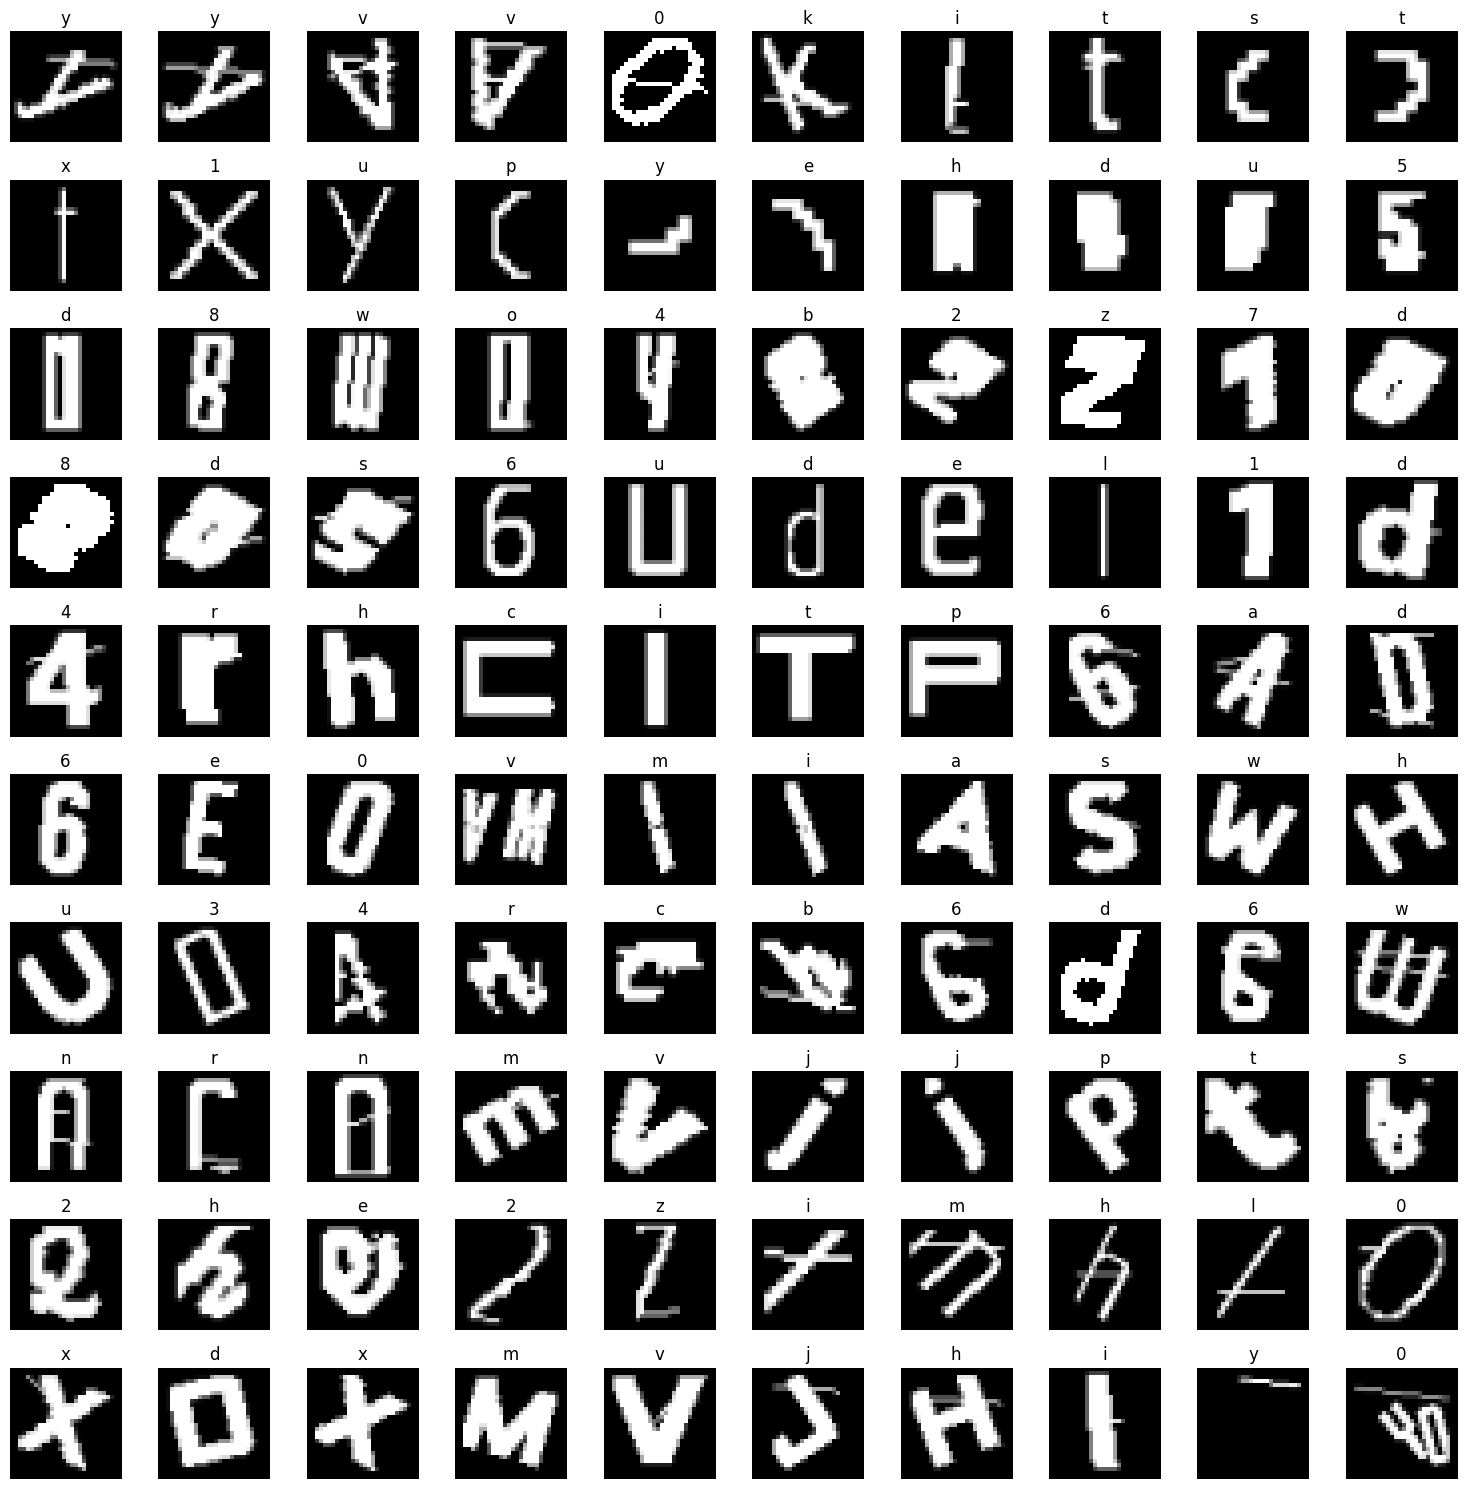

In [96]:
# Step 3: Improved CNN Classifier with more capacity
class TinyCNN(nn.Module):
    """Improved CNN for character classification with residual connections"""
    def __init__(self, num_classes=36):
        super(TinyCNN, self).__init__()
        
        # Conv Block 1 (28x28 -> 14x14)
        self.conv1a = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Conv Block 2 (14x14 -> 7x7)
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Conv Block 3 (7x7 -> 3x3)
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers with more capacity
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Block 1 with residual
        identity = x
        x = self.relu(self.bn1a(self.conv1a(x)))
        x = self.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        
        # Block 2 with residual
        x = self.relu(self.bn2a(self.conv2a(x)))
        x = self.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        
        # Block 3 with residual
        x = self.relu(self.bn3a(self.conv3a(x)))
        x = self.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        
        # Flatten and FC layers
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

# Character dataset class
class CharacterDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
        # Create character to index mapping
        all_chars = set()
        for label in labels:
            all_chars.update(label)
        
        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(all_chars))}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.num_classes = len(self.char_to_idx)
        
        print(f"Found {self.num_classes} unique characters: {sorted(all_chars)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data preparation for character classification
def prepare_character_data(images, labels, preprocessor, segmenter):
    """Extract individual characters from CAPTCHA images - IMPROVED v2 with aspect ratio preservation"""
    char_images = []
    char_labels = []
    
    for img, label in zip(images, labels):
        # Preprocess
        processed = preprocessor.preprocess(img)
        
        # Segment with balanced parameters
        char_boxes = segmenter.segment(
            processed, 
            expected_chars=len(label),
            min_char_width=3,
            max_char_width=None,
            min_char_height=5,
            aggressive_split=False
        )
        
        # Extract character crops with IMPROVED aspect ratio preservation
        for i, box in enumerate(char_boxes):
            x1, y1, x2, y2 = box
            char_crop = processed[y1:y2, x1:x2]
            
            if char_crop.size == 0:
                continue
            
            # IMPROVED: Preserve aspect ratio by padding to square first
            h, w = char_crop.shape
            max_dim = max(h, w)
            
            # Create square canvas
            square = np.zeros((max_dim, max_dim), dtype=np.uint8)
            
            # Center the character in the square
            y_offset = (max_dim - h) // 2
            x_offset = (max_dim - w) // 2
            square[y_offset:y_offset+h, x_offset:x_offset+w] = char_crop
            
            # Add border padding (10% of size)
            border = max(2, int(max_dim * 0.1))
            square_padded = cv2.copyMakeBorder(
                square, border, border, border, border,
                cv2.BORDER_CONSTANT, value=0
            )
            
            # Now resize to 28x28 (maintains aspect ratio since it's square)
            char_resized = cv2.resize(square_padded, (28, 28), interpolation=cv2.INTER_AREA)
            
            # Normalize
            char_normalized = char_resized.astype(np.float32) / 255.0
            
            char_images.append(char_normalized)
            
            # Get corresponding label character
            if i < len(label):
                char_labels.append(label[i])
            else:
                char_labels.append('?')  # Unknown character
    
    return np.array(char_images), char_labels

# Prepare character data from ALL training images
print("\n" + "="*60)
print("Extracting character data from ALL training images...")
print("="*60)

char_images, char_labels = prepare_character_data(
    train_images, train_labels_cleaned, preprocessor, segmenter
)

print(f"\nExtracted {len(char_images)} character images from {len(train_images)} CAPTCHA images")
print(f"Sample character labels: {char_labels[:10]}")

# Display sample characters
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    if i < len(char_images):
        row = i // 10
        col = i % 10
        axes[row, col].imshow(char_images[i], cmap='gray')
        axes[row, col].set_title(char_labels[i])
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()



Training character classifier on all character data...
Found 36 unique characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Epoch 1/10: Train Loss: 2.1701, Train Acc: 53.38%, Val Acc: 65.68%
Epoch 2/10: Train Loss: 1.8408, Train Acc: 64.79%, Val Acc: 68.56%
Epoch 3/10: Train Loss: 1.7493, Train Acc: 67.51%, Val Acc: 70.53%
Epoch 4/10: Train Loss: 1.6853, Train Acc: 69.87%, Val Acc: 71.39%
Epoch 5/10: Train Loss: 1.6357, Train Acc: 71.23%, Val Acc: 71.91%
Epoch 6/10: Train Loss: 1.5922, Train Acc: 72.61%, Val Acc: 72.31%
Epoch 7/10: Train Loss: 1.5554, Train Acc: 73.96%, Val Acc: 73.02%
Epoch 8/10: Train Loss: 1.5181, Train Acc: 74.97%, Val Acc: 73.31%
Epoch 9/10: Train Loss: 1.4881, Train Acc: 76.11%, Val Acc: 73.81%
Epoch 10/10: Train Loss: 1.4551, Train Acc: 76.83%, Val Acc: 73.70%


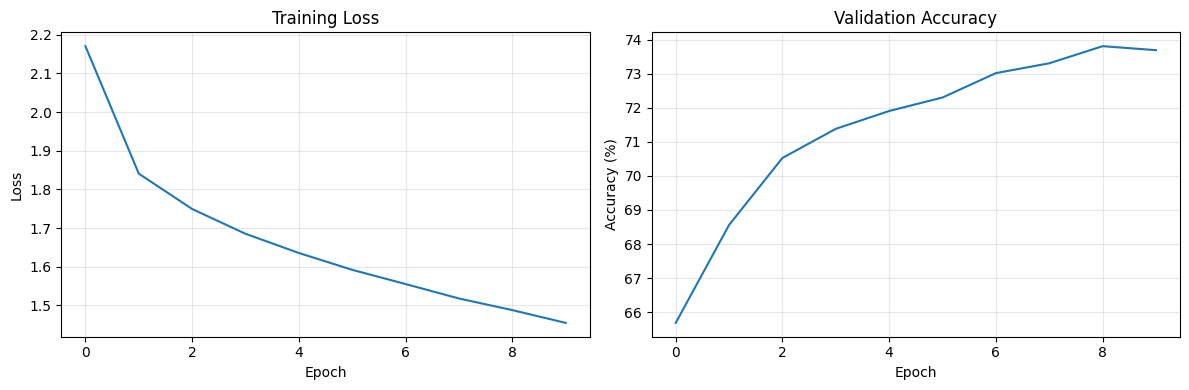


Final Training Loss: 1.4551
Final Validation Accuracy: 73.70%


In [97]:
# IMPROVED Training with Data Augmentation and Better Optimization
class DataAugmentation:
    """Simple data augmentation for character images"""
    def __init__(self, rotation_range=10, noise_std=0.05):
        self.rotation_range = rotation_range
        self.noise_std = noise_std
    
    def __call__(self, img):
        """Apply random augmentations to image tensor"""
        # img is already a tensor [1, 28, 28]
        
        # Random rotation
        if np.random.random() > 0.5:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            img_np = img.squeeze().numpy()
            center = (14, 14)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            img_np = cv2.warpAffine(img_np, M, (28, 28), borderValue=0)
            img = torch.from_numpy(img_np).unsqueeze(0)
        
        # Random noise
        if np.random.random() > 0.5:
            noise = torch.randn_like(img) * self.noise_std
            img = img + noise
            img = torch.clamp(img, 0, 1)
        
        return img


# Training the character classifier - IMPROVED VERSION
def train_character_classifier(char_images, char_labels, num_epochs=20, batch_size=32):
    """Train the CNN with data augmentation and improved optimization"""

    # Create dataset
    dataset = CharacterDataset(char_images, char_labels)

    # Split data
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create data loaders
    # FIXED: drop_last=True to avoid BatchNorm error with single-sample batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Initialize model
    model = TinyCNN(num_classes=dataset.num_classes)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # IMPROVED: Label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # IMPROVED: AdamW optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # IMPROVED: ReduceLROnPlateau scheduler (better than StepLR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3  # Removed verbose (not supported)
    )

    # Data augmentation
    augment = DataAugmentation(rotation_range=10, noise_std=0.05)

    # Training loop
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience_counter = 0
    early_stop_patience = 8

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.unsqueeze(1).float().to(device)
            
            # Apply data augmentation during training
            if epoch > 0:  # Skip first epoch for faster initial convergence
                augmented_batch = []
                for img in data:
                    augmented_batch.append(augment(img))
                data = torch.stack(augmented_batch)
            
            target = torch.tensor([dataset.char_to_idx.get(char, 0) for char in target]).to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # IMPROVED: Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data = data.unsqueeze(1).float().to(device)
                target = torch.tensor([dataset.char_to_idx.get(char, 0) for char in target]).to(device)

                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * correct / total

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val acc: {best_val_acc:.2f}%")
            break

    return model, dataset, train_losses, val_accuracies

# Train the model with more epochs and proper batch size
print("\n" + "="*60)
print("Training character classifier on all character data...")
print("="*60)

model, char_dataset, train_losses, val_accuracies = train_character_classifier(
    char_images, char_labels, num_epochs=10, batch_size=64  # Increased to 50 epochs
)

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(val_accuracies)
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

In [100]:
# Complete CAPTCHA Prediction Pipeline
class CAPTCHAPredictor:
    def __init__(self, model, char_dataset, preprocessor, segmenter, device=None):
        self.model = model
        self.char_dataset = char_dataset
        self.preprocessor = preprocessor
        self.segmenter = segmenter
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
    
    def predict_captcha(self, image):
        """Predict the full CAPTCHA text from an image"""
        # Step 1: Preprocess
        processed = self.preprocessor.preprocess(image)
        
        # Step 2: Segment characters with balanced parameters
        char_boxes = self.segmenter.segment(
            processed,
            expected_chars=None,  # Don't assume length
            min_char_width=3,
            max_char_width=None,
            min_char_height=5,
            aggressive_split=False
        )
        
        # Step 3: Extract and classify each character with IMPROVED aspect ratio preservation
        predicted_chars = []
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            
            # Extract character
            char_crop = processed[y1:y2, x1:x2]
            
            if char_crop.size == 0:
                continue
            
            # IMPROVED: Preserve aspect ratio by padding to square first
            h, w = char_crop.shape
            max_dim = max(h, w)
            
            # Create square canvas
            square = np.zeros((max_dim, max_dim), dtype=np.uint8)
            
            # Center the character in the square
            y_offset = (max_dim - h) // 2
            x_offset = (max_dim - w) // 2
            square[y_offset:y_offset+h, x_offset:x_offset+w] = char_crop
            
            # Add border padding (10% of size)
            border = max(2, int(max_dim * 0.1))
            square_padded = cv2.copyMakeBorder(
                square, border, border, border, border,
                cv2.BORDER_CONSTANT, value=0
            )
            
            # Now resize to 28x28
            char_resized = cv2.resize(square_padded, (28, 28), interpolation=cv2.INTER_AREA)
            
            # Normalize
            char_normalized = char_resized.astype(np.float32) / 255.0
            
            # Convert to tensor
            char_tensor = torch.from_numpy(char_normalized).unsqueeze(0).unsqueeze(0).to(self.device)
            
            # Predict
            with torch.no_grad():
                output = self.model(char_tensor)
                _, predicted_idx = torch.max(output.data, 1)
                predicted_char = self.char_dataset.idx_to_char[predicted_idx.item()]
                predicted_chars.append(predicted_char)
        
        # Join characters into string
        predicted_text = ''.join(predicted_chars)
        
        return predicted_text, char_boxes
    
    def visualize_prediction(self, image, predicted_text, true_label, char_boxes):
        """Visualize the prediction result"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original image
        if len(image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(image, cmap='gray')
        axes[0].set_title(f"True: {true_label}")
        axes[0].axis('off')
        
        # Prediction with boxes
        processed = self.preprocessor.preprocess(image)
        axes[1].imshow(processed, cmap='gray')
        axes[1].set_title(f"Predicted: {predicted_text}")
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=2, edgecolor='red', facecolor='none')
            axes[1].add_patch(rect)
        
        axes[1].axis('off')
        
        # Color code the title based on correctness
        if predicted_text == true_label:
            axes[1].title.set_color('green')
        else:
            axes[1].title.set_color('red')
        
        plt.tight_layout()
        plt.show()

# Initialize predictor
print("\n" + "="*60)
print("Initializing CAPTCHA Predictor...")
print("="*60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = CAPTCHAPredictor(model, char_dataset, preprocessor, segmenter, device)

print(f"Using device: {device}")
print("Predictor ready!")



Initializing CAPTCHA Predictor...
Using device: cpu
Predictor ready!



Testing predictor on sample images...

--- Sample 1 ---
True Label:      xzrf2
Predicted Text:  xzil
Match: False


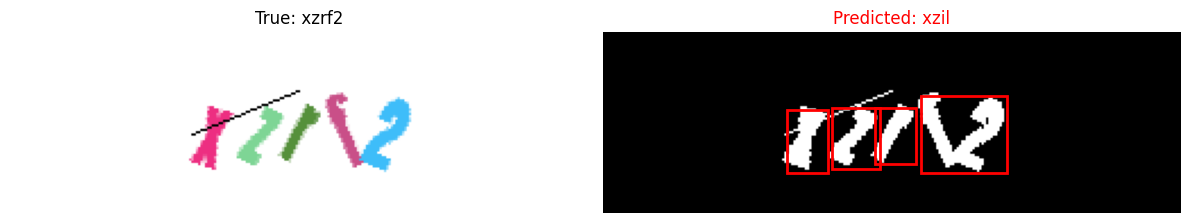


--- Sample 2 ---
True Label:      s29j
Predicted Text:  sasi79j
Match: False


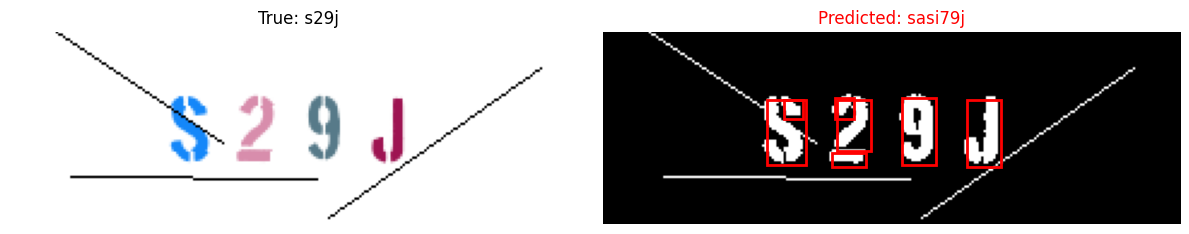


--- Sample 3 ---
True Label:      hc0ulqk
Predicted Text:  eyf
Match: False


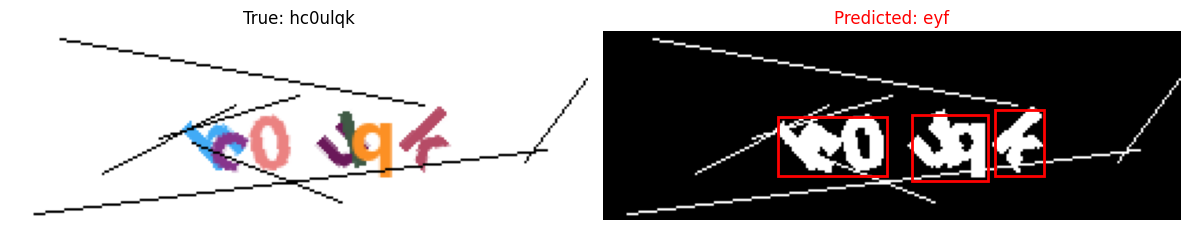


--- Sample 4 ---
True Label:      845ios
Predicted Text:  845ie6
Match: False


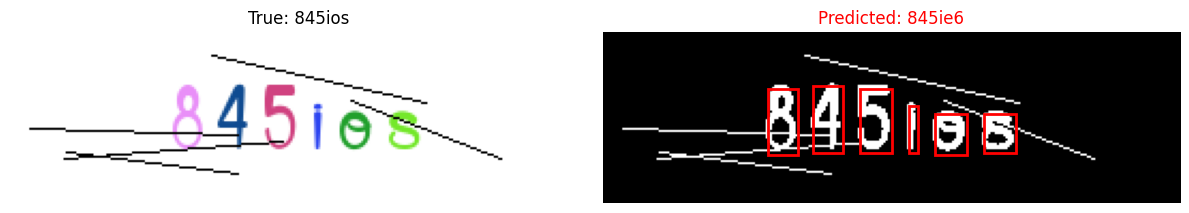


--- Sample 5 ---
True Label:      kjlcnst
Predicted Text:  kjlcnst
Match: True


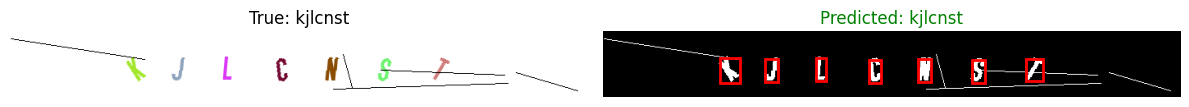


Evaluating on FULL test set...
Processing 2000 test images...
Progress: 0/2000 (0.0%)
Progress: 100/2000 (5.0%)
Progress: 200/2000 (10.0%)
Progress: 300/2000 (15.0%)
Progress: 400/2000 (20.0%)
Progress: 500/2000 (25.0%)
Progress: 600/2000 (30.0%)
Progress: 700/2000 (35.0%)
Progress: 800/2000 (40.0%)
Progress: 900/2000 (45.0%)
Progress: 1000/2000 (50.0%)
Progress: 1100/2000 (55.0%)
Progress: 1200/2000 (60.0%)
Progress: 1300/2000 (65.0%)
Progress: 1400/2000 (70.0%)
Progress: 1500/2000 (75.0%)
Progress: 1600/2000 (80.0%)
Progress: 1700/2000 (85.0%)
Progress: 1800/2000 (90.0%)
Progress: 1900/2000 (95.0%)

Completed: 2000/2000 (100%)

EVALUATION RESULTS
Total test images: 2000
Exact match accuracy: 31.20% (624/2000)
Character-level accuracy: 55.88% (7616/13628)

Sample incorrect predictions:
Image 0: True='xzrf2', Predicted='xzil'
Image 1: True='s29j', Predicted='sasi79j'
Image 2: True='hc0ulqk', Predicted='eyf'
Image 3: True='845ios', Predicted='845ie6'
Image 5: True='trejedm', Predicted=

In [99]:
# Test predictor on sample images
print("\n" + "="*60)
print("Testing predictor on sample images...")
print("="*60)

n_test_samples = min(5, len(test_images))

for i in range(n_test_samples):
    print(f"\n--- Sample {i+1} ---")
    predicted_text, char_boxes = predictor.predict_captcha(test_images[i])
    true_label = test_labels_cleaned[i]
    
    print(f"True Label:      {true_label}")
    print(f"Predicted Text:  {predicted_text}")
    print(f"Match: {predicted_text == true_label}")
    
    predictor.visualize_prediction(test_images[i], predicted_text, true_label, char_boxes)

# Evaluate on full test set
print("\n" + "="*60)
print("Evaluating on FULL test set...")
print("="*60)

correct = 0
total = len(test_images)
char_correct = 0
char_total = 0

predictions = []
ground_truths = []

print(f"Processing {total} test images...")

for i, (img, true_label) in enumerate(zip(test_images, test_labels_cleaned)):
    if i % 100 == 0:
        print(f"Progress: {i}/{total} ({i/total*100:.1f}%)")
    
    try:
        predicted_text, _ = predictor.predict_captcha(img)
        predictions.append(predicted_text)
        ground_truths.append(true_label)
        
        # Exact match accuracy
        if predicted_text == true_label:
            correct += 1
        
        # Character-level accuracy
        for pred_char, true_char in zip(predicted_text, true_label):
            char_total += 1
            if pred_char == true_char:
                char_correct += 1
        
        # Account for length differences
        if len(predicted_text) != len(true_label):
            char_total += abs(len(predicted_text) - len(true_label))
    
    except Exception as e:
        predictions.append("")
        ground_truths.append(true_label)
        print(f"Error on image {i}: {e}")

print(f"\nCompleted: {total}/{total} (100%)")

# Calculate metrics
exact_match_accuracy = 100 * correct / total
char_accuracy = 100 * char_correct / char_total if char_total > 0 else 0

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Total test images: {total}")
print(f"Exact match accuracy: {exact_match_accuracy:.2f}% ({correct}/{total})")
print(f"Character-level accuracy: {char_accuracy:.2f}% ({char_correct}/{char_total})")

# Show some incorrect predictions
print("\n" + "="*60)
print("Sample incorrect predictions:")
print("="*60)

incorrect_samples = []
for i, (pred, true) in enumerate(zip(predictions, ground_truths)):
    if pred != true:
        incorrect_samples.append((i, pred, true))

if incorrect_samples:
    for idx, pred, true in incorrect_samples[:10]:
        print(f"Image {idx}: True='{true}', Predicted='{pred}'")

# Save the trained model
print("\n" + "="*60)
print("Saving trained model...")
print("="*60)

# Save model weights
model_path = 'captcha_classifier.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'char_to_idx': char_dataset.char_to_idx,
    'idx_to_char': char_dataset.idx_to_char,
    'num_classes': char_dataset.num_classes,
}, model_path)

print(f"Model saved to: {model_path}")
print(f"Number of classes: {char_dataset.num_classes}")
print(f"Characters: {sorted(char_dataset.char_to_idx.keys())}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"✓ Trained on {len(train_images)} CAPTCHA images")
print(f"✓ Extracted {len(char_images)} character samples")
print(f"✓ Tested on {len(test_images)} CAPTCHA images")
print(f"✓ Exact match accuracy: {exact_match_accuracy:.2f}%")
print(f"✓ Character accuracy: {char_accuracy:.2f}%")
print(f"✓ Model saved to: {model_path}")
print("="*60)
